# EELS quantification 

**Roberto dos Reis**<br>
Northwestern University

- Jun/2020

- This week we will cover EELS analysis using Hyperspy package.


" HyperSpy is an open source Python library which provides tools to facilitate the interactive data analysis of multi-dimensional datasets that can be described as multi-dimensional arrays of a given signal (e.g. a 2D array of spectra a.k.a spectrum image) " - from hyperspy official [webpage](hyperspy.org) 


- You can find more information about this notebook in the links below as well as more information abouth the original authors of this example 

# Hyperspy Tutorial

## EELS analysis of perovskite oxides

This tutorial shows the various functionalities in HyperSpy which is used to analyse Electron Energy Loss Spectroscopy data, using EELS datasets from a perovskite oxide heterostructure.

It assumes some knowledge on how to use HyperSpy, like loading datasets and how the basic signals work.

This notebook requires **HyperSpy 1.4.2** or later.

## Author

7/6/2016 Magnus Nord - Developed for HyperSpy workshop at Scandem conference 2016

## Changes

* 3/8/2016 Updated for HyperSpy 1.1. Added note about Gatan Digital Micrograph GOS.
* 20/7/2019 Katherine MacArthur - Checked for Hyperspy 1.5.1 and commented out sections requiring Gatan GOS files.
* 30/7/2019 Magnus Nord - Minor text improvements for M&M19 short course

## Table of contents

1. <a href='#spec_and_data'> Specimen & Data</a>
2. <a href='#simple_quant'> Simple quantification</a>
3. <a href='#curve_fitting_quant'> Curve fitting quantification</a>
4. <a href='#fine_structure_analysis'> Fine structure analysis</a>
5. <a href='#fine_structure_ok'> Fine structure oxygen-K edge</a>

# <a id='spec_and_data'></a>1. Specimen & Data

This notebook was used for the HyperSpy workshop at the Norwegian University of Science and Technology for the Scandem 2016 conference, 7 June 2016.

The data was acquired on a Jeol ARM200cF using a Gatan Quantum ER with DualEELS capabilities.

The data itself is from La$_{0.7}$Sr$_{0.3}$MnO$_3$ thin films deposited on SrTiO$_3$. In the Fine Structure example parts of the film has been exposed to a very long electron beam exposure, inducing oxygen vacancies.

The datasets has been binned to reduce the file size and processing time.

# <a id='simple_quant'></a> 2. Simple quantification


Firstly we use some IPython magic to import the right plotting libraries, 

In [1]:
%matplotlib notebook

Then import HyperSpy. If the `traitsui` GUI is installed and enable, you will have two warnings *WARNING:hyperspy_gui_traitsui* warning about the incompatibility of the `notebook` matplotlib backend with the `traitsui` GUI. This can be safely be ignored if you don't to use any GUIs or if you are using the `ipwidgets` GUI. Alternatively, you can use the 'qt' matplotlib backend which is compatible with the `traitsui` GUI.

In [2]:
import hyperspy.api as hs

First we take a look at an EELS line scan across an La$_{0.7}$Sr$_{0.3}$MnO$_3$/SrTiO$_3$ thin film, in the file `datasets/LSMO_STO_linescan.hdf5`.

In [ ]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

The core loss data has several peaks: Ti-L$_{2,3}$, O-K, Mn-L$_{2,3}$ and La-M$_{4,5}$. We can navigate the line scan using the navigation window, and by moving the red line. Visualize this by using the `plot()` method

In [ ]:
s.plot()

Now we can quantifiy the first edge (Ti-L$_{2,3}$, 460 eV, 0-10 nm). Firstly by removing the background with the `remove_background` method, then integrating the Ti-L$_{2,3}$ edge. Move the red line in the navigation figure towards the top part (0-10 nm, x axis). Then drag a span from about 400 to 440 eV in Figure 2.

Next, untick the "Fast" button in the dialog box under figure 2, and press Apply.

Note: sometimes the background removal doesn't work properly. If this happens, reload the data using the command above (`s = hs.load("datasets/LSMO_STO_linescan.hdf5"`). Then rerun the `s.remove_background()` command.

In [ ]:
s.remove_background()

To integrate the Ti-L32 edge interactively we can use a `hs.roi.SpanROI` region of interest.

Drag the green span in the plot to just include the Ti-L$_{2,3}$ edge

In [ ]:
roi = hs.roi.SpanROI(left=450, right=600)
s.plot()
roi.add_widget(s, axes=["Energy loss"])

Finally, we integrate the signal within the `SpanROI`, then plot it

In [ ]:
s_ti = s.isig[roi].integrate1D(axis="Energy loss")

In [ ]:
s_ti.plot()

We can also perform the same operations in one single line if interactivity is not required, by chaining the methods.

- Reload the data from `datasets/LSMO_STO_linescan.hdf5`
- In one line: remove the background (`remove_background`), crop the signal to only include the Ti-L peak (`isig`) and sum the energy loss axis (`integrate1D`)
- Plot the output from this

In [ ]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

In [ ]:
s_ti = s.remove_background(signal_range=(405.,448.)).isig[448.:480.].integrate1D(axis="Energy loss")

In [ ]:
s_ti.plot()

# <a id='curve_fitting_quant'></a> 3. Curve fitting quantification

Now, lets do some more advanced quantification using HyperSpy's extensive modelling framework. Firstly we load the low loss and core loss spectra: `datasets/LSMO_STO_linescan_low_loss.hdf5` and `datasets/LSMO_STO_linescan.hdf5`.

In [ ]:
s_ll = hs.load("datasets/LSMO_STO_linescan_low_loss.hdf5")

In [ ]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

Hyperspy contains Ray Egerton's Hydrogenic cross-sections which are only able to apply curve fitting for the K and L edges. Because this dataset also contains the La-M edge we ideally want to be able to fit this too. In order to do that we could make use of the Digital Micrograph Hartree-Slater cross section files, if you have access to them. Firstly we'll have to tell HyperSpy where to find these files, since they are not included in HyperSpy. Go to the "EELS" tab, then set "GOS directory" to the "H-S GOS Tables" folder. Note that unfortunately this requires a license of Gatan Digital Micrograph.

In the following section, any command that requires the presence of Hartree-Slater cross-sections is commented out. Therefore it is possible to run using only the uncommented lines with the in-built cross sections. In the case where a cell contains two similar commands only one should be run depending on what cross-sections file you have access to.

*Remember*: The `#` simple converts a line of code to a comment line. Therefore any code line with `#` in the front of it will be treated as a comment rather than code and so will be ignored. Use this to control what gets run in this section.

In [ ]:
hs.preferences.gui()

In these EELS signals, the metadata has been populated with some of the experimental parameters, which we can access in the `metadata` attribute

In [ ]:
s.metadata

Firstly we want to fix the zero point for the energy axis using the zero loss peak.

Plot it, and use the zoom functionality (the box button) in the Signal plot to zoom in on the zero loss peak.

It is offset by approximetely 0.6 eV.

In [ ]:
s_ll.plot()

To fix this we use `align_zero_loss_peak`. The subpixel argument interpolates the data, so we get sub-pixel alignment. Using the `also_align` argument, we can also apply the alignment on a another signal. For example when using dualEELS, where both the low loss and core loss is acquired quasi-simultaneously. Note the other signals must have the same navigation shape as the low loss signals.

In [ ]:
s_ll.align_zero_loss_peak(subpixel=True, also_align=[s])

By doing this, we aligned both our low loss and core loss spectra. Plot the low loss signal to see if the alignment worked, by zooming in on the zero loss peak.

In [ ]:
s_ll.plot()

We have to add the elements which is present in the sample to `s` using the `add_elements` method: `Mn`, `O` and `Ti`

In [ ]:
#For Hydrogenic cross sections run this line.
s.add_elements(('Mn','O','Ti'))
#For Hartree-Slater cross sections run this line.
#s.add_elements(('Mn', 'O', 'Ti', 'La'))

We can see which elements have been added to a signal with the `metadata` attribute

In [ ]:
s.metadata

Then we make a model out of the core loss spectrum using `create_model`. The low loss spectrum is convolved with the model, which means plural scattering is automatically taken into account. In addition this leads to better fits.

**NOTE:** creating this model requires using the GOS files from Gatan Digital Micrograph. If you don't have these files only K and L edges can be created using Hydrogenic cross sections. If you do have them but HyperSpy can't find them in the default location, you can specify the location using `hs.preferences.gui()`.

In [ ]:
#For Hydrogenic cross sections run this line, in order crop out the La edge.
m = s.isig[0.:825.].create_model(ll=s_ll)
#For Hartree-Slater cross sections run this line.
#m = s.create_model(ll=s_ll)

The model consist of many different EELSCLEdge components, including a component for the plasmon background. These are automatically created for the `EELSSpectrum` signal class.

To see all the components in a model, use the `components` attribute

In [ ]:
m.components

We can fit the model to the experimental data by using the `multifit` function, with the `kind=smart` fitting. Which is fits in a way optimized for EELS data, by fitting from the lowest to the highest energy losses.

In [ ]:
m.multifit(kind='smart')

Visualize the result of this fitting with the `plot` method

In [ ]:
m.plot()

We can check the error of the fitting

In [ ]:
#For Hydrogenic cross sections run this line.
edges = ("Ti_L3", "Mn_L3","O_K")
#For Hartree-Slater cross sections run this line.
#edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

In [ ]:
edges

In [ ]:
hs.plot.plot_spectra([m[edge].intensity.as_signal("std") for edge in edges], legend=edges)

This fitted mostly ok, but it is still not very good. Firstly we can move the EELSCLedge component onsets interactively, by firstly plotting the model, and then running `m.enable_adjust_position()`

In [ ]:
m.plot()
m.enable_adjust_position()

Or manually, by directly changing the parameters within the EELSCLedge component. The parameter is called `onset_energy`, and the value itself is set with `onset_energy.value`

In [ ]:
m.components.O_K.onset_energy.value = 528

However, to change it for all the probe positions we have to use `assign_current_value_to_all()`

In [ ]:
m.components.O_K.onset_energy.assign_current_value_to_all()

We repeat this for the Manganese edges. Since this is an L-edge, there are 3 different ones. However, we only have to set the Mn-L$_3$: the L$_2$ and L$_1$ is a set to an energy relative to the L$_3$.

(If we're using the Hydrogenic model, there is only the Mn-L$_3$)

In [ ]:
m.components.Mn_L3.onset_energy.value

In [ ]:
# Only with Hartree-Slater cross-sections
#m.components.Mn_L2.onset_energy.value

In [ ]:
m.components.Mn_L3.onset_energy.value = 638.5
m.components.Mn_L3.onset_energy.assign_current_value_to_all()

The bad fitting to the data is also due to the fine structure not currently taken into account by the model. To get a good fit, we can either not fit to the fine structure regions, or model them somehow.
The easiest way is defining certain regions as fine structure with the `enable_fine_structure` method

In [ ]:
m.enable_fine_structure()

This will produce a much better fit, but will be much slower (~2 minutes). Rerun the fitting using `multifit`

In [ ]:
m.multifit(kind='smart')

Visualize the result using `plot`.

Now the fit is much better, due to the model taking into account the fine structure.

In [ ]:
m.plot()

Now we can can have a look at the relative intensity from the individual EELS-edges using plot_spectra

In [ ]:
#For Hydrogenic cross sections run this line.
edges = ("Ti_L3", "Mn_L3", "O_K")
#For Hartree-Slater cross sections run this line.
#edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

In [ ]:
hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

While the fitting looks nicer, we can clearly improve this. Firstly the intensities are negative where it should be zero. Secondly, the fine structure regions can be fine tuned. Especially the Mn-L1 fine structure window can be reduced

In [ ]:
# Only with Hartree-Slater cross-sections
#m.components.Mn_L1.fine_structure_width = 15

To avoid the negative values we use bounded fitting, where we can constrain the parameter values between certain values. The `bmin` and `bmax` properties in the parameters are used for this.

Here, lets set `bmin` to 0.0 for all the intensity parameters

In [ ]:
m.components.Mn_L3.intensity.bmin = 0.0

In [ ]:
# Only with Hartree-Slater cross-sections
#m.components.La_M5.intensity.bmin = 0.0

In [ ]:
m.components.Ti_L3.intensity.bmin = 0.0

In [ ]:
m.components.O_K.intensity.bmin = 0.0

Use `multifit` with `bounded=True` and `fitter="leastsq"` to do this model fitting

In [ ]:
m.multifit(fitter="leastsq", kind='smart', bounded=True)

Visualize the results

In [ ]:
m.plot()

In [ ]:
hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

# <a id='fine_structure_analysis'></a> 4. Fine structure analysis

Here we take a look at a linescan from a La$_{0.7}$Sr$_{0.3}$MnO$_3$ thin film, where parts of the film has been bombarded with the electron beam for an extended time.

Load the `datasets/LSMO_linescan.hdf5` file

In [3]:
s = hs.load("datasets/LSMO_linescan.hdf5")

Plot the signal, and use the red line in the navigation plot to explore the data. There is clearly something going on in the middle on both the oxygen and the manganese edges. In addition, there are some thickness changes during the line scan.

<IPython.core.display.Javascript object>


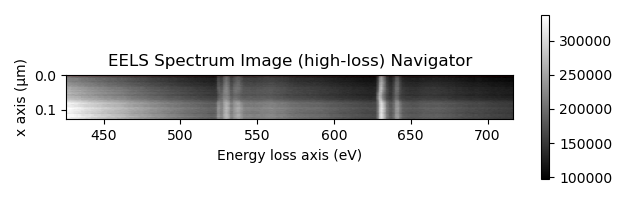

<IPython.core.display.Javascript object>


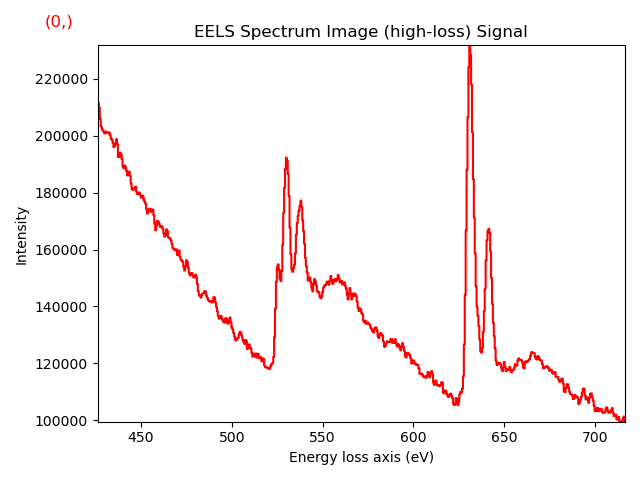

In [4]:
s.plot()

Using the low loss signal, we make sure the energy scale is properly calibrated: `datasets/LSMO_linescan_low_loss.hdf5`

In [5]:
s_ll = hs.load("datasets/LSMO_linescan_low_loss.hdf5")

Plot the low loss signal

<IPython.core.display.Javascript object>


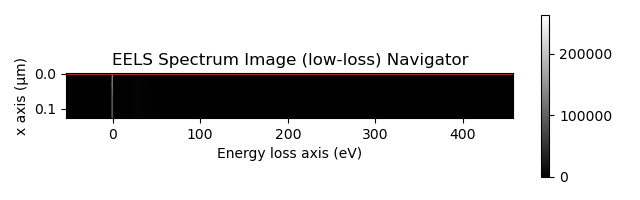

<IPython.core.display.Javascript object>


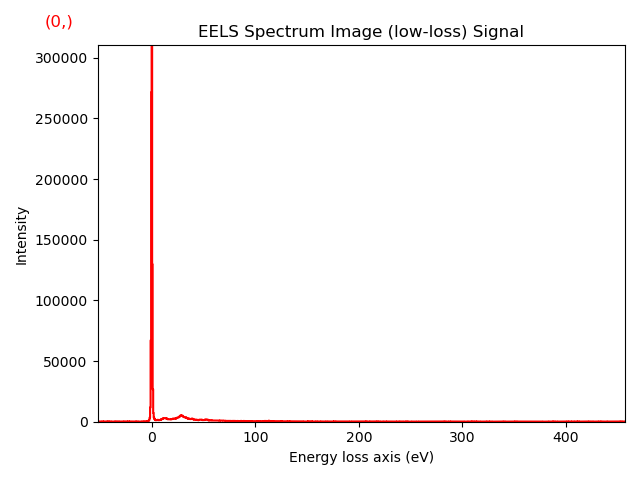

In [6]:
s_ll.plot()

The zero loss peak is not well aligned at 0 eV energy loss, so we should align both it and the core loss signal

In [7]:
s_ll.align_zero_loss_peak(also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	3.23
std:	0.249

min:	3
Q1:	3
median:	3
Q3:	3.5
max:	3.5


Plot the low loss signal to check the alignment.

Now the zero loss peak has been shifted to 0 energy loss, and likewise the core loss spectrum `s` has also been aligned

<IPython.core.display.Javascript object>


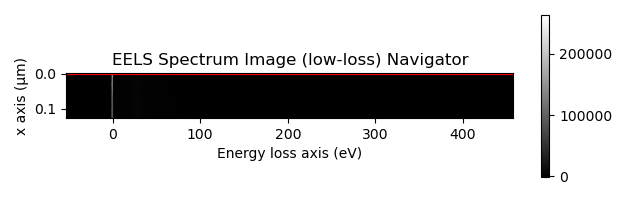

<IPython.core.display.Javascript object>


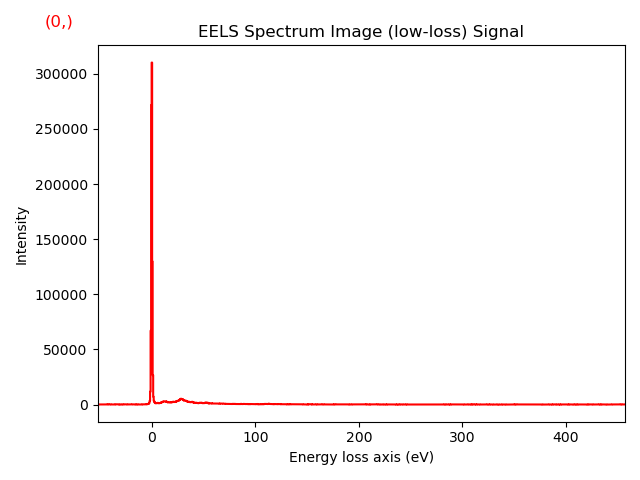

In [8]:
s_ll.plot()

We can also calculate the relative thickness using the low loss, with the `estimate_thickness` method. We'll have to specify the end of the zero loss beam, which for cold field emissions guns 3.0 eV seems to work well.

In [9]:
s_thickness = s_ll.estimate_thickness(threshold=3.0)

It would also be possible to use hyperspy to determine the threshold itself using:
    
    th = wedge.estimate_elastic_scattering_threshold()
    s_ll.estimate_thickness(threshold=th)

Plotting this gives the relative thickness and, as expected, there is an increase towards the end of the line scan

<IPython.core.display.Javascript object>


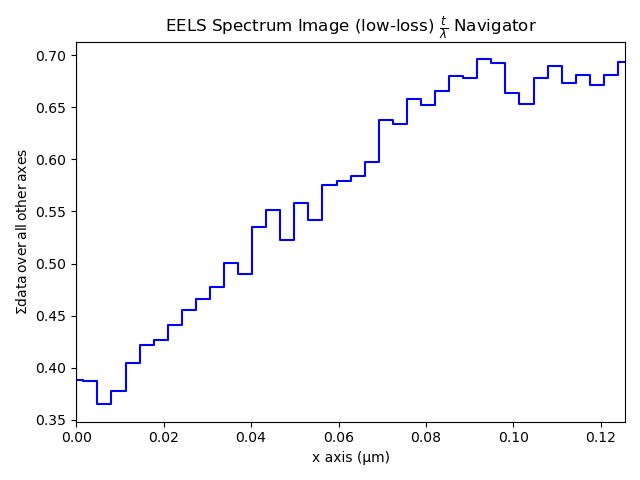

In [10]:
s_thickness.plot()

# <a id='fine_structure_ok'></a> 5. Fine structure: oxygen K-edge
Lets take a closer look at the oxygen-K edge, firstly by removing the plasmon background with `remove_background`. We'll also reload the data from disk in case any changes were made. Note: this will overwrite the `s` spectrum with the cropped one. 


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	3.23
std:	0.249

min:	3
Q1:	3
median:	3
Q3:	3.5
max:	3.5


<IPython.core.display.Javascript object>


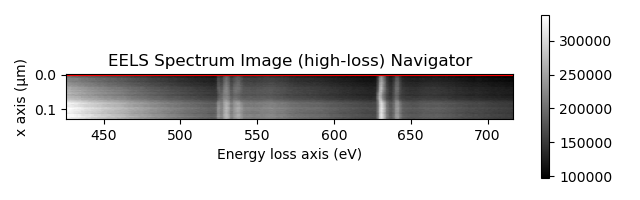

<IPython.core.display.Javascript object>


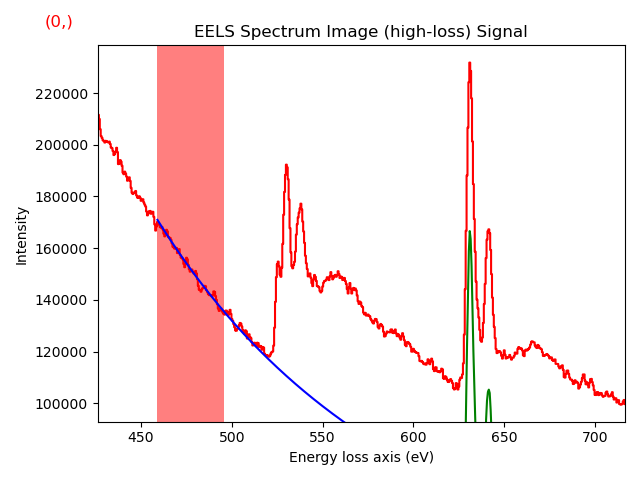

<IPython.core.display.Javascript object>


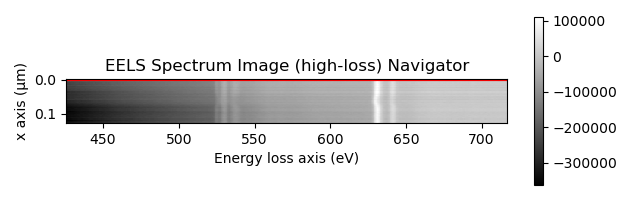

<IPython.core.display.Javascript object>


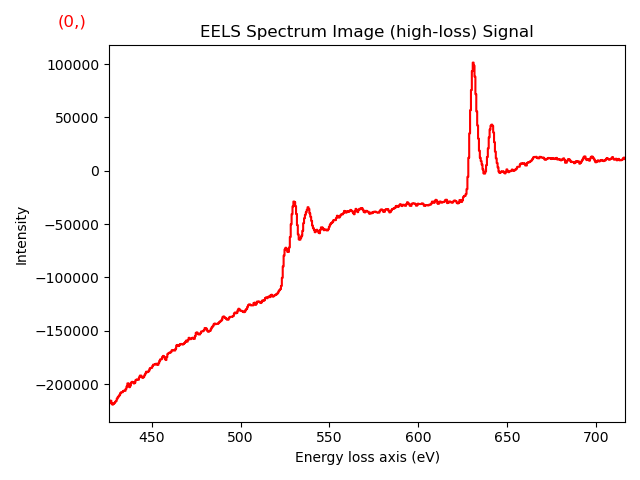

In [11]:
s = hs.load("datasets/LSMO_linescan.hdf5")
s_ll = hs.load("datasets/LSMO_linescan_low_loss.hdf5")
s_ll.align_zero_loss_peak(also_align=[s])
s.remove_background()

This makes it much easier to compare the different positions. Pressing 'e' with the spectrum window highlighted gives a second spectrum picker, which can be moved independently of the first one

We can then do Fourier ratio deconvolution to remove the effects of plural scattering: `fourier_ratio_deconvolution`

In [ ]:
s_deconvolved = s.fourier_ratio_deconvolution(s_ll)

Plotting this, we see that the thickness effects has been greatly reduced towards the end of the line scan

In [ ]:
s_deconvolved.plot()

### Fine structure modelling

Having had a qualitative look at the data, we can try to quantify some of these changes. We do this by making making a model of the oxygen-K edge signal. Firstly we crop the signal, leaving only the Oxygen-K edge (490 to 590 eV).

Use the `crop_signal1D` method in the core loss signal.

In [ ]:
s.crop_signal1D()

Make a model from the cropped core loss signal.

As we've already removed the background, we set `auto_background=False`. In addition, since we haven't added any elements to the signal, we get no ionization edges.

In [ ]:
m = s.create_model(ll=s_ll, auto_background=False)

So currently, the model does not contain any components

In [ ]:
m.components

We can try to model some of the fine structure with 1-D Gaussians components: `hs.model.components1D.Gaussian`

In [ ]:
g1 = hs.model.components1D.Gaussian()

We add this component to the model using the `append` method. (Similar to how you add an element to a Python list)

In [ ]:
m.append(g1)

This added the gaussian component to the model

In [ ]:
m.components

Then we can fit this Gaussian to the largest of the O-K peaks with the `fit_component` method by dragging a span over the peak between 528 and 533 eV. Run it first with the "Only Current" option ticked, then run it without to fit the whole dataset

In [ ]:
m.fit_component(g1)

Having fitted the Gaussian to the experimental data, we can plot how the Gaussian three parameters change over the line scan with the `plot` method in the Gaussian component: `A`, `sigma` and `centre`. The `A` changes quite a bit, which is probably (among others) related to thickness changes. However, there are clear changes in the `sigma` parameter in the region with the electron beam damage

In [ ]:
g1.plot()

The next step is to fit the second largest peak (535 and 541 eV) with a Gaussian.

Make another Gaussian component, and add it to the model.

In [ ]:
g2 = hs.model.components1D.Gaussian()

In [ ]:
m.append(g2)

Use `fit_component` with the `signal_range=(535., 541.)` argument so we don't have to select the region using the GUI.

Also use `only_current=False` to fit all the positions in the line scan.

In [ ]:
m.fit_component(g2, signal_range=(535., 541.), only_current=False)

Plot the model fitting results with `plot()`

In [ ]:
m.plot()

However, this time the final fit does not look very good. This is due to the two components being fitted independently of each other. We should fit both of them at the same time. Firstly, we have to set the `signal_range` which is where the model will fit to the experimental data. Here we select the region spanning the two major peaks (528-541 eV)

In [ ]:
m.set_signal_range()

Refit the model using `multifit`

In [ ]:
m.multifit()

After fitting, we reset the signal range (`reset_signal_range`) so we can see the full range of the signal

In [ ]:
m.reset_signal_range()

Plot the model to check the fitting results

In [ ]:
m.plot()

Lastly, we can fit the small "pre-peak" as well. First we "lock" the two Gaussian we have already fitted using the `set_parameters_not_free` methond

In [ ]:
g1.set_parameters_not_free()

In [ ]:
g2.set_parameters_not_free()

Then we add another Gaussian, and fit it using `fit_component` between 522 and 527 eV

In [ ]:
g3 = hs.model.components1D.Gaussian()

In [ ]:
m.append(g3)

In [ ]:
m.fit_component(g3, signal_range=(522., 527.), only_current=False)

Then we set the signal range to cover all the three peaks, from 520 eV to 541 eV

In [ ]:
m.set_signal_range(520., 541.)

And set the `g1` and `g2` components free using `set_parameters_free`

In [ ]:
g1.set_parameters_free()

In [ ]:
g2.set_parameters_free()

Then we refit the model using `multifit`.

This fits all the three components to the experimental data, which hopefully gives a good fit.

In [ ]:
m.multifit()

Reset the signal range, and plot the model to see the fitting results

In [ ]:
m.reset_signal_range()

In [ ]:
m.plot()

We can then compare the different parameters in the components, by getting the component values as signals using the `as_signal` method in the components.

Firstly get the ratio of the `A` parameters for the largest peak and the pre-peak, by using `as_signal` and dividing the signals. Then plot the results.

In [ ]:
g1_g3_ratio = g1.A.as_signal()/g3.A.as_signal()

In [ ]:
g1_g3_ratio.plot()

Then get the difference in centre positions between the largest peak and the pre-peak, via the `centre` parameter in the Gaussians.

In [ ]:
g1_g3_position = g1.centre.as_signal()-g3.centre.as_signal()

In [ ]:
g1_g3_position.plot()

Lastly, get the ratio of the `sigma` parameters in the largest peak and the pre-peak.

In [ ]:
g1_g3_sigma = g1.sigma.as_signal()/g3.sigma.as_signal()

In [ ]:
g1_g3_sigma.plot()

In all of the comparisons there are some large changes in the regions with beam damage. However, the values can vary a great deal. This is most likely due to the g1 fitted to the pre-peak is not so clearly defined in these regions. Leading to potentially bad fitting.